<a href="https://colab.research.google.com/github/pranavrelds/Sentiment-analysis-quora-insincere-question-classification/blob/main/Copy_of_Quora_Insincere_Questions_Classification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [ ]:
# https://github.com/amaiya/ktrain
!pip install -q ktrain

     |████████████████████████████████| 25.3MB 129kB/s 
     |████████████████████████████████| 6.8MB 30.8MB/s 
     |████████████████████████████████| 983kB 48.0MB/s 
     |████████████████████████████████| 266kB 49.7MB/s 
     |████████████████████████████████| 1.9MB 9.3MB/s 
     |████████████████████████████████| 1.2MB 47.3MB/s 
     |████████████████████████████████| 471kB 54.4MB/s 
     |████████████████████████████████| 901kB 47.7MB/s 
     |████████████████████████████████| 3.3MB 53.8MB/s 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import ktrain
from ktrain import text
import tensorflow as tf

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Configurations

In [ ]:
DIR = '/content/drive/MyDrive/Quora Insincere Questions Classification/'
BERT = '/content/drive/MyDrive/Quora Insincere Questions Classification/BERT'

DF_TRAIN = pd.read_csv(DIR+'train.csv')
MODEL_NAME = 'bert'
MAX_LEN = 128
BATCH_SIZE = 10
EPOCHS = 2

# Model

In [ ]:
# Adding labels to dataframe
DF_TRAIN['label'] = DF_TRAIN['target'].astype('category')
DF_TRAIN['label'] = DF_TRAIN['label'].cat.rename_categories(['sincere', 'insincere'])

# Downsampled just to speed up the process
sincere = DF_TRAIN[DF_TRAIN.target == 0]
insincere = DF_TRAIN[DF_TRAIN.target == 1]

TRAIN_DOWNSAMPLED = pd.concat([resample(
                     sincere,
                     replace = False,
                     n_samples = len(insincere)), insincere])

print('Number of questions in the original data : ', DF_TRAIN.shape[0])
print('Number of questions in the downsampled data : ', TRAIN_DOWNSAMPLED.shape[0])

Number of questions in the original data :  1306122
Number of questions in the downsampled data :  161620


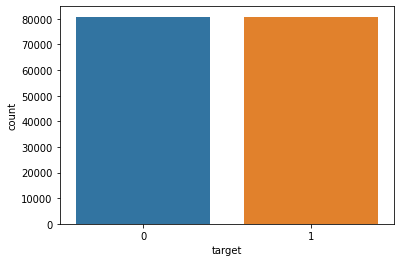

In [ ]:
# Distribution of classes
sns.countplot(TRAIN_DOWNSAMPLED.target)

## Splitting Data into Training,Test and Validation Sets

In [ ]:
data, test_data = train_test_split(TRAIN_DOWNSAMPLED, test_size=0.2, random_state=0)
training_data, validation_data = train_test_split(data, test_size=0.2, random_state=0)
print('Number of question in training set : ', training_data.shape[0])
print('Number of question in validation set : ', validation_data.shape[0])
print('Number of question in test set : ', test_data.shape[0])

Number of question in training set :  103436
Number of question in validation set :  25860
Number of question in test set :  32324


## Preprocess the Data

In [ ]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=training_data,
                                                                   text_column = 'question_text',
                                                                   label_columns = 'label',
                                                                   val_df = validation_data,
                                                                   maxlen = MAX_LEN,
                                                                   preprocess_mode = MODEL_NAME)

['insincere', 'sincere']
        insincere  sincere
159107        0.0      1.0
857992        0.0      1.0
59738         0.0      1.0
549860        1.0      0.0
402781        1.0      0.0
['insincere', 'sincere']
        insincere  sincere
344395        1.0      0.0
490646        1.0      0.0
957536        0.0      1.0
663210        1.0      0.0
72196         0.0      1.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


## Load the BERT Model and Instantiate a Learner object

In [ ]:
model = text.text_classifier(name = 'bert',
                             train_data = (X_train, y_train), 
                             preproc = preproc)

Is Multi-Label? False
maxlen is 128
done.


In [ ]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train),
                   val_data = (X_test, y_test),
                   batch_size = BATCH_SIZE)

## Train the Model

In [ ]:
learner.fit_onecycle(lr = 2e-5, epochs = EPOCHS)
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save(BERT)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/2
10344/10344 [==============================] - 5126s 494ms/step - loss: 0.2533 - accuracy: 0.9018 - val_loss: 0.2295 - val_accuracy: 0.9155
Epoch 2/2
10344/10344 [==============================] - 5105s 493ms/step - loss: 0.1666 - accuracy: 0.9407 - val_loss: 0.2107 - val_accuracy: 0.9238


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Prediction

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)
y_pred_test = predictor.predict(test_data.question_text.tolist())
test = test_data['question_text'][:10].tolist()
results = pd.DataFrame(test, y_pred_test[:10])
results

,0
insincere,Who is the creator of the Arab Spring Strategy...
sincere,Is it good to replace marijuana with herion?
sincere,Is there any exercise machine that works speci...
insincere,Did Democrats really complain Russian agents t...
insincere,Can Indian people not defecate in public?
sincere,How do you get negative voltage on a circuit?
sincere,Does repressing your feelings lead to a habit ...
sincere,What is so amazing about the broadway show Ham...
sincere,What are some of your Thanksgiving nightmares?
insincere,The FBI is investigating whether a top Russian...


**Scope of Improvement :**

Insincere questions could be augmented with libraries such as nlpaug (https://github.com/makcedward/nlpaug)